In [2]:
import os
import numpy as np
from sisl import *
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# option to create the input fdf file for siesta
# graphene = geom.graphene(1.44)
# plot(graphene)
# open('RUN.fdf', 'w').write("""%include STRUCT.fdf
# SystemLabel siesta_2
# PAO.BasisSize SZP
# MeshCutoff 250. Ry
# CDF.Save true
# CDF.Compress 9
# SaveHS true
# SaveRho true
# %block kgrid.MonkhorstPack
#   61  1 1 0.
#    1 61 1 0.
#    0  0 1 0.
# %endblock
# """)
# graphene.write('STRUCT.fdf')

In [4]:
# system label 
syslab = "MnO"
fdf = get_sile(syslab + ".fdf")
H = fdf.read_hamiltonian()
print(H)

Hamiltonian{non-zero: 47852, orthogonal: False,
 Spin{polarized, kind=f},
 Geometry{na: 4, no: 56,
  Atoms{species: 2,
   Atom{Mn, Z: 25, mass(au): 54.94000, maxR: 3.47190,
    AtomicOrbital{4sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 3.4719, q0: 2.0}},
    AtomicOrbital{4sZ2, q0: 0.0, SphericalOrbital{l: 0, R: 3.2615, q0: 0.0}},
    AtomicOrbital{3dxyZ1, q0: 1.0, SphericalOrbital{l: 2, R: 2.0538000000000003, q0: 5.0}},
    AtomicOrbital{3dyzZ1, q0: 1.0, SphericalOrbital{l: 2, R: 2.0538000000000003, q0: 5.0}},
    AtomicOrbital{3dz2Z1, q0: 1.0, SphericalOrbital{l: 2, R: 2.0538000000000003, q0: 5.0}},
    AtomicOrbital{3dxzZ1, q0: 1.0, SphericalOrbital{l: 2, R: 2.0538000000000003, q0: 5.0}},
    AtomicOrbital{3dx2-y2Z1, q0: 1.0, SphericalOrbital{l: 2, R: 2.0538000000000003, q0: 5.0}},
    AtomicOrbital{3dxyZ2, q0: 0.0, SphericalOrbital{l: 2, R: 1.1998000000000002, q0: 0.0}},
    AtomicOrbital{3dyzZ2, q0: 0.0, SphericalOrbital{l: 2, R: 1.1998000000000002, q0: 0.0}},
    AtomicOrbital{3dz2Z2

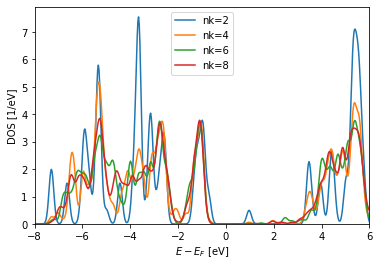

In [47]:
# The convergency of DOS
E = np.linspace(-8, 6, 500)
for nk in [2, 4, 6, 8]:
    bz = MonkhorstPack(H, [nk, nk, nk])
    plt.plot(E, bz.apply.average.DOS(E), label='nk={}'.format(nk));
plt.xlim(E[0], E[-1]); plt.ylim(0, None)
plt.xlabel(r'$E - E_F$ [eV]')
plt.ylabel(r'DOS [1/eV]')
plt.legend();

Orbital index of $Mn-dt2g$: [2, 3, 5, 7, 8, 10]
Orbital index of $Mn-deg$: [4, 6, 9, 11]
Orbital index of $Mn-s$: [0, 1]
Orbital index of $O-p$: [2, 3, 4, 5, 6, 7]
Orbital index of $O-s$: [0, 1]


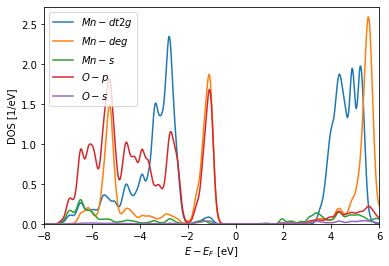

In [85]:
# Projected DOS
bz = MonkhorstPack(H, [8,8,8])
# orbitals to project
# each line contains four lists: atom label, orb.l, orb.m, and index to compute
# definition of orb.m:
# for s-shell, orb.m = 0
# for p-shell, py:-1, pz:0, px:1
# for d-shell, dxy:-2, dyz:-1, dz2:0, dxz:1, dx2-y2:2
# proj_info = [[[0,1],[2],[-2],[],"$Mn-dxy$"],\
#             [[0,1],[2],[-1],[],"$Mn-dyz$"],\
#             [[0,1],[2],[0],[],"$Mn-dz2$"],\
#             [[0,1],[2],[1],[],"$Mn-dxz$"],\
#             [[0,1],[2],[2],[],"$Mn-dx2$"],\
#             [[2,3],[1],[-1,0,1],[],"$O-p$"]]
proj_info = [[[0,1],[2],[-2,-1,1],[],"$Mn-dt2g$"],\
            [[0,1],[2],[0,2],[],"$Mn-deg$"],\
            [[0,1],[0],[0],[],"$Mn-s$"],\
            [[2,3],[1],[-1,0,1],[],"$O-p$"],\
            [[2,3],[0],[0],[],"$O-s$"]]
# number of projected dos required above
nlines = len(proj_info)
# involved species in the projection
proj_species = []
for n in range(nlines):
    proj_species.append(proj_info[n][0][0])
proj_species = list(set(proj_species))

for s in proj_species:
    for i, orb in enumerate(H.geometry.atoms[s]):
        for n in range(nlines):
            if (s in proj_info[n][0]) and (orb.l in proj_info[n][1]) \
            and (orb.m in proj_info[n][2]):
                proj_info[n][3].append(i)

for n in range(nlines):
    print("Orbital index of " + proj_info[n][4] + ": {}".format(proj_info[n][3]))
# Get all orbitals
allorbs = []
for n in range(nlines):
    allorbs.append(np.add.outer(H.geometry.a2o(proj_info[n][0]), proj_info[n][3]).ravel())
def wrap(PDOS):
    results = []
    for n in range(nlines):
        results.append(PDOS[allorbs[n], :].sum(0))
    return np.array(results)
pDOS = bz.apply.average.PDOS(E, wrap=wrap)
for n in range(nlines):
    plt.plot(E, pDOS[n, :], label=proj_info[n][4]);
plt.xlim(E[0], E[-1]); plt.ylim(0, None)
plt.xlabel(r'$E - E_F$ [eV]')
plt.ylabel(r'DOS [1/eV]')
plt.legend();

In [91]:
# compute weight for projected band structure
weight = []
for n in range(nlines):
    weight.append([])
def wrap_fatbands(eigenstate):
    # The eigenstate object has several features.
    # For now we will simply calculate the <psi_i| S(k) | psi_i> weight for
    # the orbitals we are interested in.
    norm2 = eigenstate.norm2(sum=False)
    for n in range(nlines):
        weight[n].append(norm2[:, allorbs[n]].sum(-1))
    return eigenstate.eig
# Define the band-structure
bz = BandStructure(H, [[0] * 3, [0.5, 0, 0], [0.5, 0.5, 0], [0] * 3], 400,
                   name=[r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$'])

# Calculate all eigenvalues
eig = bz.apply.array.eigenstate(wrap=wrap_fatbands).T
for n in range(nlines):
    weight[n] = np.array(weight[n]).T


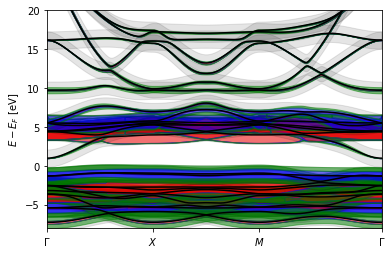

In [96]:
linear_k, k_tick, k_label = bz.lineark(True)

Emin, Emax = -8, 20
# This is to determine the width of the fat-bands
# The width of the fat-bands is dependent on the energy range and also on the variety
# of contributions.
dE = (Emax - Emin) / 25.
plt.ylabel(r'$E-E_F$ [eV]')
plt.xlim(linear_k[0], linear_k[-1]);
plt.xticks(k_tick, k_label);
plt.ylim(Emin, Emax);

# Now plot the bands
for i, e in enumerate(eig):
    r = np.abs(weight[0][i, :] * dE) 
    b = np.abs(weight[1][i, :] * dE)
    g = np.abs(weight[3][i, :] * dE) 
    plt.plot(linear_k, e, color='k'); # black-line (band-structure)
    # Full fat-band
    plt.fill_between(linear_k, e - dE, e + dE, color='k', alpha=0.1);
    # r
    plt.fill_between(linear_k, e - (r), e + (r), color='r', alpha=0.5);
    # b
    plt.fill_between(linear_k, e + (r), e + (r + b), color='b', alpha=0.5);
    plt.fill_between(linear_k, e - (r), e - (r + b), color='b', alpha=0.5);
    # g
    plt.fill_between(linear_k, e + (r + b), e + (r + b + g), color='g', alpha=0.5);
    plt.fill_between(linear_k, e - (r + b + g), e - (r + b), color='g', alpha=0.5);
    

In [27]:
np.stack((np.array([[1,1],[2,2]]),np.array([2,3])))

ValueError: all input arrays must have the same shape